# Temporal Difference Learning

* ***Bootstrap***: Learning without waiting for a final outcome. "Learning a guess from a guess" 

## TD Prediction

Policy evaluation in MC methods wat for the return. Every-visit MC for non-stationary environments

\begin{align}
V(S_t) \leftarrow V(S_t) + \alpha\left[ {\color{blue}G_t} - V(S_t) \right]
\end{align}

in contrast a simple TD method updates after every timestep

\begin{align}
V(S_t) \leftarrow V(S_t) + \alpha\left[ {\color{blue}R_{t+1} + \gamma V(S_{t+1})} - V(S_t) \right]
\end{align}

with the respective target in blue.
This is also called *TD(0)* or *one-step TD*.

With the the *TD error*

\begin{align}
\delta_t := R_{t+1} + \gamma V(S_{t+1}) - V(S_t
\end{align}

When $V$ is constant during a episode the *TD errors* can be written as 

\begin{align}
G_t - V(S_t) = \sum_{k=1}^{T-1} \gamma^{k-t} \delta_k
\end{align}


In [1]:
!pip install -r ../requirements.txt

In [2]:
import numpy as np
import dm_env
from tqdm import tqdm


def tabular_td0(environment: dm_env.Environment, policy: np.array, step_size: float = 0.1, number_of_episodes: int = 10, max_episode_length: int = 20,
                report_rate: int = 10, V: np.array = None, quite: bool = True, rng: np.random.RandomState = None) -> np.array:
    rng = rng or np.random.RandomState(1)
    # observation and state are the same
    specs = environment.observation_spec()
    state_count = specs.maximum - specs.minimum + 1

    if V is None:
        V = rng.uniform(0., 1., (state_count,))  # V[terminal] should be 0

    for episode_index in tqdm(range(number_of_episodes), desc='tabular TD(0)', disable=quite):
        state = rng.randint(specs.minimum, specs.maximum)
        environment.state = state
        for _ in range(max_episode_length):
            action = policy[state]
            step = environment.step(action)
            V[state] += step_size * \
                (step.reward + step.discount*V[step.observation] - V[state])
            state = step.observation
            if step.last():
                environment.reset()
                break

        if (episode_index + 1) % report_rate == 0:
            yield V


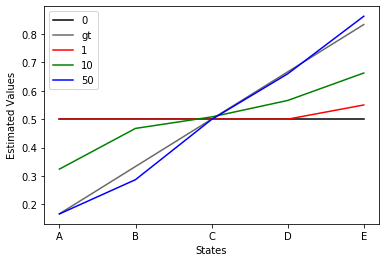

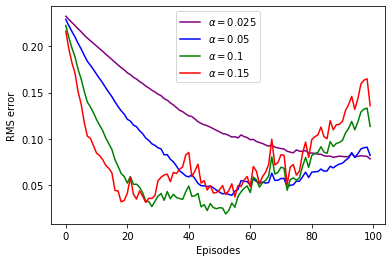

In [3]:
from dm_env import TimeStep, specs
import matplotlib.pyplot as plt


class RandomWalk(dm_env.Environment):
    def __init__(self, seed: int = 1) -> None:
        # states from 0 to 4
        #
        self._rng = np.random.RandomState(seed)
        self._reset()

    def reset(self) -> TimeStep:
        self._reset()
        return dm_env.restart(observation=self.state)

    def step(self, _) -> TimeStep:
        delta = self._rng.choice([-1, 1])
        self.state += delta

        if self.state < 0:
            return dm_env.termination(reward=0., observation=0)
        elif self.state > 4:
            return dm_env.termination(reward=1., observation=4)
        else:
            return dm_env.transition(reward=0., observation=self.state)

    def _reset(self):
        self.state = 2

    def observation_spec(self) -> specs.BoundedArray:
        return specs.BoundedArray(
            shape=(1,),
            dtype=int,
            name="position",
            minimum=0,
            maximum=4,
        )

    def action_spec(self) -> specs.DiscreteArray:
        return specs.BoundedArray(
            shape=(0,),
            dtype=int,
            name="no action",
            minimum=0,
            maximum=0,
        )


def random_walk_example():
    policy = np.zeros((5,), dtype=int)  # not needed here
    gt_value = np.asarray(range(1, 6)) / 6

    # change
    steps = {
        1: 'red',
        10: 'green',
        50: 'blue',
    }
    V = np.asarray([0.5]*5)
    plt.plot(V, color='black', label='0')
    plt.plot(gt_value, color='dimgrey', label='gt')
    env = RandomWalk()
    for i, value in enumerate(tabular_td0(environment=env, policy=policy, V=V, step_size=0.1, number_of_episodes=100, report_rate=1), 1):
        if i in steps:
            plt.plot(value, color=steps[i], label=f'{i}')
    plt.legend()
    plt.xticks(range(5), ['A', 'B', 'C', 'D', 'E'])
    plt.xlabel('States')
    plt.ylabel('Estimated Values')
    plt.show()

    # parameter sweep
    trials = {
        'purple': 0.025,
        'blue': 0.05,
        'green': 0.1,
        'red': 0.15,
    }

    for color, step_size in trials.items():
        errors = []
        env = RandomWalk()
        V = np.asarray([0.5]*5)
        for value in tabular_td0(environment=env, policy=policy, V=V, step_size=step_size, number_of_episodes=100, report_rate=1):
            error = np.sqrt(np.mean((gt_value - value)**2))
            errors.append(error)

        plt.plot(errors, color=color, label=f'$\\alpha = {step_size:0.2}$')

    plt.legend()
    plt.xlabel('Episodes')
    plt.ylabel('RMS error')
    plt.show()


random_walk_example()


## Optimality of TD(0)

* batch training
* maximum-likelihood estimate of the Markov process
* TD(0) converges faster as MC, because it computes the true certainty-equivalent estimate
* *certainty-equivalent* would be the optimal solution, but rarely feasible

## Sarsa: On-policy TD Control

\begin{align}
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha\left[R_{t+1} + \gamma Q\left( S_{t+1}, A_{t+1}\right) - Q(S_t, A_t) \right]
\end{align}

In [4]:
from typing import Callable


def base_td0_control(target: Callable[[np.array, TimeStep, int], float],
                     environment: dm_env.Environment, epsilon: float = 0.1, step_size: float = 0.5,
                     number_of_episodes: int = 10, max_episode_length: int = 100,
                     step_hook: Callable[[np.array, int],  None] = None, termination_hook: Callable[[bool, int], None] = None,
                     rng: np.random.RandomState = None):
    rng = rng or np.random.RandomState(1)

    specs = environment.observation_spec()
    state_count = specs.maximum - specs.minimum + 1
    action_count = environment.action_spec().num_values

    # Q = rng.uniform(-1., .0, size=(state_count, action_count))
    Q = np.zeros(shape=(state_count, action_count))

    def choose_action(state):
        if rng.random() < epsilon:
            return rng.randint(0, action_count-1)
        else:
            return np.argmax(Q[state])

    for _ in tqdm(range(number_of_episodes)):
        current_state = environment.state

        action = choose_action(current_state)
        success = False
        for step_index in range(max_episode_length):
            timestep = environment.step(action)
            next_action = choose_action(timestep.observation)
            Q[current_state, action] += step_size * \
                (target(Q, timestep, next_action) -
                 Q[current_state, action])

            if timestep.last():
                if step_hook is not None:
                    step_hook(Q, environment.state)
                if termination_hook is not None:
                    termination_hook(True, step_index)
                success = True
                environment.reset()
                if step_hook is not None:
                    step_hook(Q, environment.state)
                break

            if step_hook is not None:
                step_hook(Q, current_state)
            action = next_action
            current_state = timestep.observation

        if not success:
            environment.reset()
            termination_hook(False, step_index)

    return Q


def sarsa_on_policy_td0_control(environment: dm_env.Environment, epsilon: float = 0.1, step_size: float = 0.5,
                                number_of_episodes: int = 10, max_episode_length: int = 100,
                                step_hook: Callable[[np.array, int],  None] = None, termination_hook: Callable[[bool, int], None] = None,
                                rng: np.random.RandomState = None):

    def target(Q, timestep, action):
        next_Q = Q[timestep.observation, action]
        return timestep.reward + timestep.discount*next_Q

    return base_td0_control(target=target,
                            environment=environment, epsilon=epsilon, step_size=step_size,
                            number_of_episodes=number_of_episodes, max_episode_length=max_episode_length,
                            step_hook=step_hook, termination_hook=termination_hook,
                            rng=rng)


In [5]:
from typing import List
from gridworld_video import Position


class WindyGridWorld(dm_env.Environment):
    def __init__(self, width: int = 10, height: int = 7, wind: List[int] = None, start: Position = None, goal: Position = None) -> None:
        self._width = width
        self._height = height
        self._start = start or Position(0, 3)
        self._goal = goal or Position(7, 3)
        self._wind = wind or [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
        actions_dict = {
            'north': Position(0, -1),
            'south': Position(0, 1),
            'west': Position(-1, 0),
            'east': Position(1, 0)
        }

        self.actions = [actions_dict[k] for k in sorted(actions_dict)]
        self._reset()

    def reset(self) -> dm_env.TimeStep:
        self._reset()
        return dm_env.restart(observation=self.state)

    def step(self, action) -> dm_env.TimeStep:
        delta = self.actions[action]
        location = self.location()
        wind = Position(0, self._wind[location.x])
        candidate = location + delta + wind
        candidate = candidate.crop(self._height, self._width)
        if candidate == self._goal:
            return dm_env.termination(reward=0., observation=self._position_to_index(candidate))
        else:
            self.state = self._position_to_index(candidate)
            return dm_env.transition(reward=-1., observation=self.state)

    def observation_spec(self) -> specs.BoundedArray:
        return specs.BoundedArray(
            shape=(1,),  # current locations
            dtype=int,
            name="location index",
            minimum=0,
            maximum=self._width * self._height-1,
        )

    def action_spec(self) -> specs.DiscreteArray:
        return specs.DiscreteArray(dtype=int, num_values=4, name="directions")

    def _position_to_index(self, position: Position) -> int:
        return position.y*self._width + position.x

    def location(self):
        return self._index_to_position(self.state)

    def _index_to_position(self, index: int) -> Position:
        x = index % self._width
        y = index // self._width
        return Position(x, y)

    def _reset(self):
        self.state = self._position_to_index(self._start)


### Running SARSA on Windy Gridworld
In the middle a wind blows the actor up.Therefore the actor must reach the windless right edge.
### Failed approaches during During training

  0%|          | 0/200 [00:00<?, ?it/s]

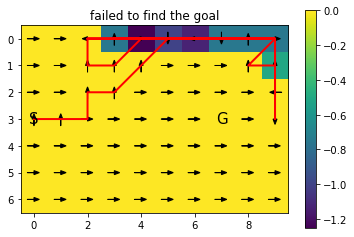

  0%|          | 1/200 [00:00<00:27,  7.16it/s]

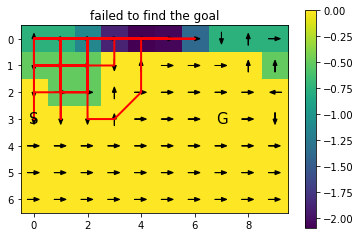

  1%|          | 2/200 [00:00<00:30,  6.57it/s]

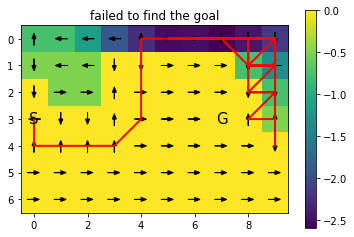

  2%|▏         | 3/200 [00:00<00:27,  7.15it/s]

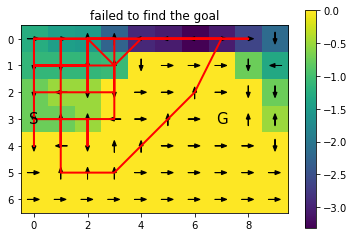

  2%|▏         | 4/200 [00:00<00:26,  7.52it/s]

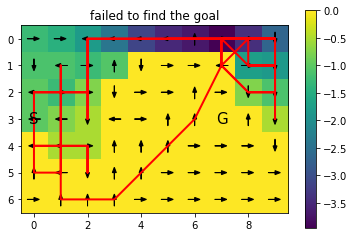

  2%|▎         | 5/200 [00:00<00:25,  7.72it/s]

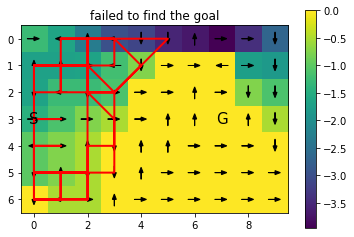

  3%|▎         | 6/200 [00:00<00:24,  7.86it/s]

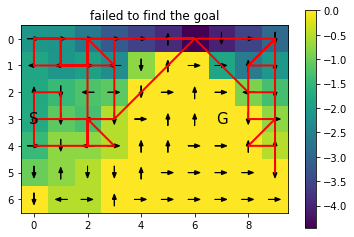

  4%|▎         | 7/200 [00:00<00:24,  7.89it/s]

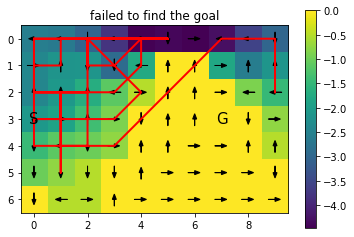

  4%|▍         | 8/200 [00:01<00:28,  6.79it/s]

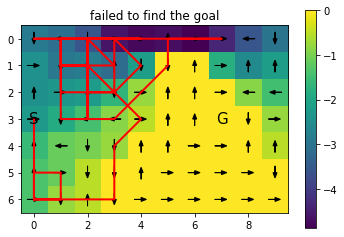

  4%|▍         | 9/200 [00:01<00:27,  7.04it/s]

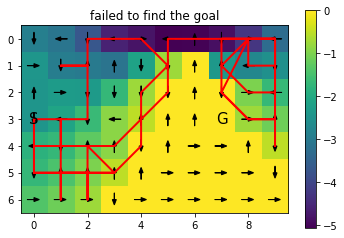

  5%|▌         | 10/200 [00:01<00:26,  7.25it/s]

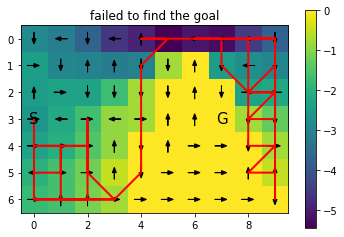

  6%|▌         | 11/200 [00:01<00:25,  7.40it/s]

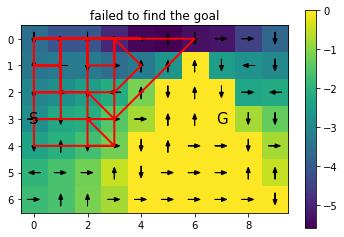

  6%|▌         | 12/200 [00:01<00:25,  7.52it/s]

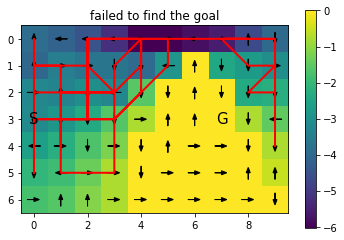

  6%|▋         | 13/200 [00:01<00:26,  6.96it/s]

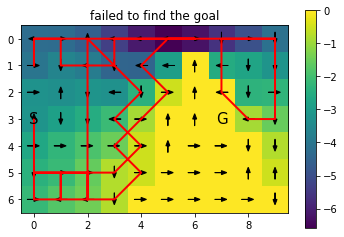

  7%|▋         | 14/200 [00:01<00:25,  7.24it/s]

During training progress the path gets faster

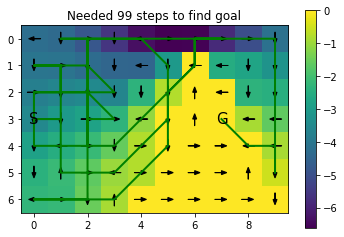

  8%|▊         | 15/200 [00:02<00:25,  7.35it/s]

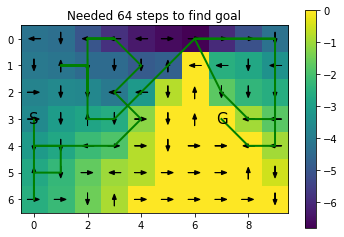

  8%|▊         | 16/200 [00:02<00:24,  7.48it/s]

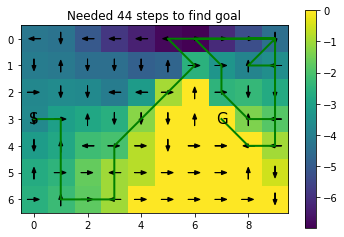

  8%|▊         | 17/200 [00:02<00:24,  7.56it/s]

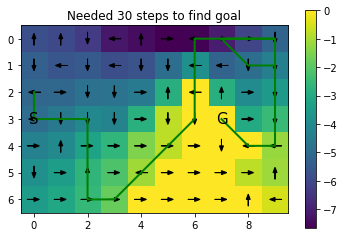

 12%|█▏        | 24/200 [00:02<00:08, 20.97it/s]

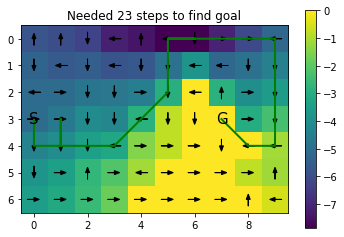

 14%|█▎        | 27/200 [00:02<00:08, 19.48it/s]

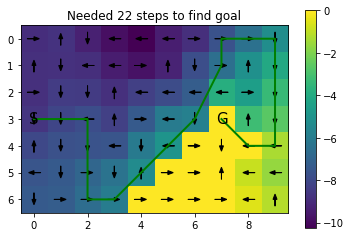

 29%|██▉       | 58/200 [00:02<00:01, 75.77it/s]

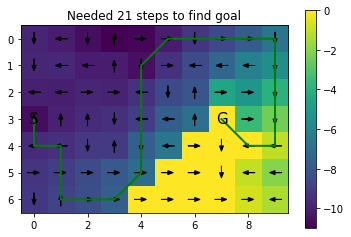

 37%|███▋      | 74/200 [00:02<00:01, 87.23it/s]

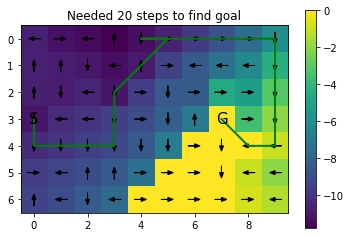

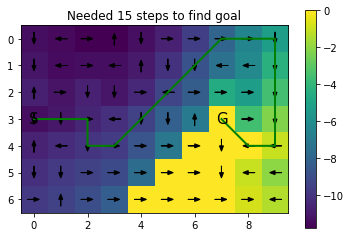

 42%|████▏     | 83/200 [00:03<00:01, 64.72it/s]

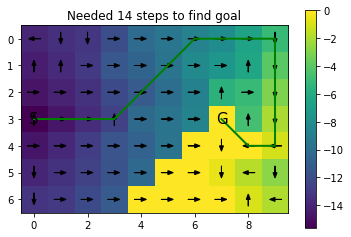

100%|██████████| 200/200 [00:03<00:00, 58.71it/s] 


### Progress from Episode to Episode
In the begining it fails to find the goal
Later the paths getting shorter and shorter

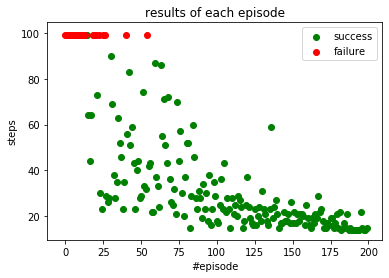

In [6]:
from gridworld_video import Frame, draw_frame
from IPython.display import display, Markdown


def windy_gridworld():
    width = 10
    height = 7
    start = Position(0, 3)
    goal = Position(7, 3)
    wind = [0, 0, 0, -1, -1, -1, -2, -2, -1, 0]
    env = WindyGridWorld(width=width, height=height,
                         start=start, goal=goal, wind=wind)

    frames: List[Frame] = []
    episodes: List = []
    current_trace = []

    def step_hook(value, location):
        x = location % width
        y = location // width
        marker = Position(x, y)
        policy = np.argmax(value, axis=1)
        policy = np.reshape(policy, (height, width))
        value = np.max(value, axis=1)
        value = np.reshape(value, (height, width))
        current_trace.append(marker)
        frames.append(Frame(data=value, marker=marker,
                            trace=[*current_trace], policy=policy))

    class TerminationHook:
        def __init__(self):
            self.best_route = None

        def __call__(self, success: bool, step_index: int):
            episodes.append((success, step_index))
            if self.best_route is None and not success:
                pass
            elif success and (self.best_route is None or self.best_route > step_index):
                if self.best_route is None:
                    display(
                        Markdown('During training progress the path gets faster'))
                self.best_route = step_index
                pass
            else:
                del current_trace[:]
                return

            frame = frames[-1]
            if success:
                frame.trace.append(goal)
                title = f'Needed {step_index} steps to find goal'
            else:
                title = 'failed to find the goal'
            draw_frame(title=title, frame=frame, start=start,
                       goal=goal, arrow_map=arrow_map, success=success)
            del current_trace[:]

    def arrow_map(index: int):
        action = env.actions[index]
        return action.x, action.y

    display(Markdown('### Running SARSA on Windy Gridworld\n'
                     'In the middle a wind blows the actor up.'
                     'Therefore the actor must reach the windless right edge.\n'
                     '### Failed approaches during During training'))

    sarsa_on_policy_td0_control(
        environment=env, epsilon=0.05, step_size=0.5, number_of_episodes=200, step_hook=step_hook, termination_hook=TerminationHook())

    display(Markdown('### Progress from Episode to Episode\n'
                     'In the begining it fails to find the goal\n'
                     'Later the paths getting shorter and shorter'))

    successfull_episodes = [(i, steps)
                            for i, (success, steps) in enumerate(episodes) if success]
    failed_episodes = [(i, steps)
                       for i, (success, steps) in enumerate(episodes) if not success]
    plt.scatter(*zip(*successfull_episodes), color='green', label='success')
    plt.scatter(*zip(*failed_episodes), color='red', label='failure')
    plt.xlabel('#episode')
    plt.ylabel('steps')
    plt.legend()
    plt.title('results of each episode')
    plt.show()


windy_gridworld()


## Q-learning: Off-policy TD Control

\begin{align}
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha\left[{\color{blue} R_{t+1} + \gamma\max_a Q(S_{t+1}, a)} - Q(S_t, A_t) \right]
\end{align}

In [8]:
def qlearning_td0_control(environment: dm_env.Environment, epsilon: float = 0.1, step_size: float = 0.5,
                                number_of_episodes: int = 10, max_episode_length: int = 100,
                                step_hook: Callable[[np.array, int],  None] = None, termination_hook: Callable[[bool, int], None] = None,
                                rng: np.random.RandomState = None):

    def target(Q, timestep, action):
        next_Q = Q[timestep.observation, :]
        return timestep.reward + timestep.discount*np.max(next_Q)

    return base_td0_control(target=target,
                            environment=environment, epsilon=epsilon, step_size=step_size,
                            number_of_episodes=number_of_episodes, max_episode_length=max_episode_length,
                            step_hook=step_hook, termination_hook=termination_hook,
                            rng=rng)

### Running SARSA on Windy Gridworld
In the middle a wind blows the actor up.Therefore the actor must reach the windless right edge.
### Failed approaches during During training

  0%|          | 0/200 [00:00<?, ?it/s]

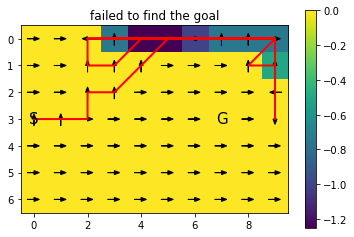

  0%|          | 1/200 [00:00<00:26,  7.46it/s]

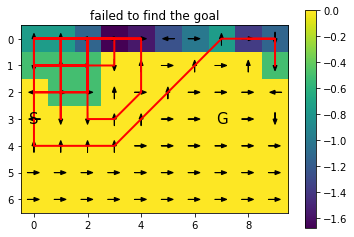

  1%|          | 2/200 [00:00<00:27,  7.32it/s]

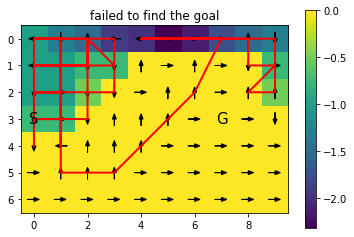

  2%|▏         | 3/200 [00:00<00:26,  7.37it/s]

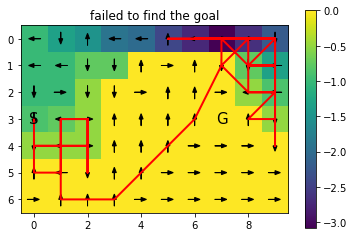

  2%|▏         | 4/200 [00:00<00:31,  6.31it/s]

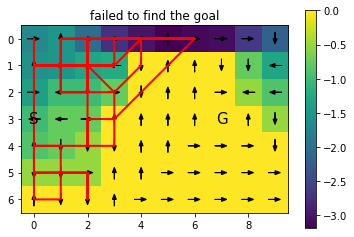

  2%|▎         | 5/200 [00:00<00:28,  6.78it/s]

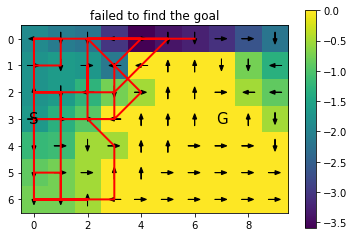

  3%|▎         | 6/200 [00:00<00:27,  7.07it/s]

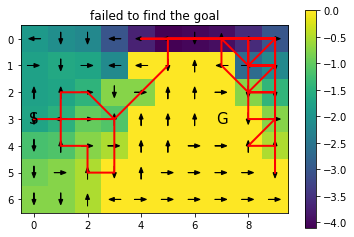

  4%|▎         | 7/200 [00:00<00:26,  7.22it/s]

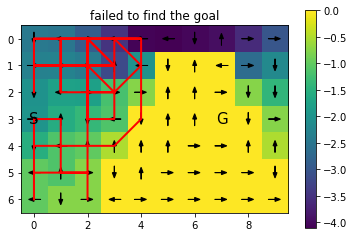

  4%|▍         | 8/200 [00:01<00:26,  7.28it/s]

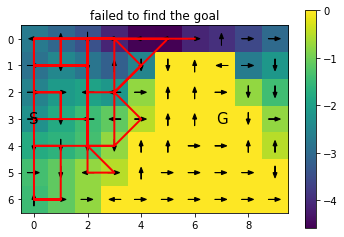

  4%|▍         | 9/200 [00:01<00:25,  7.49it/s]

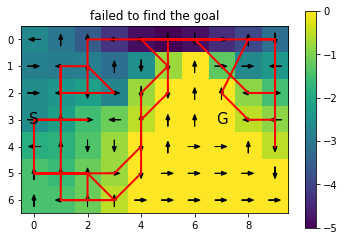

  5%|▌         | 10/200 [00:01<00:27,  6.88it/s]

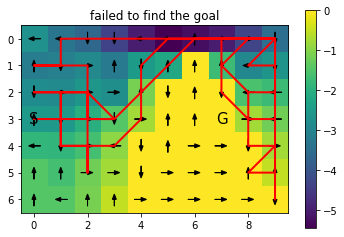

  6%|▌         | 11/200 [00:01<00:26,  7.14it/s]

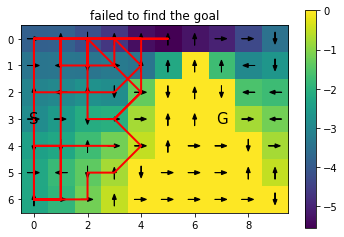

  6%|▌         | 12/200 [00:01<00:26,  7.08it/s]

During training progress the path gets faster

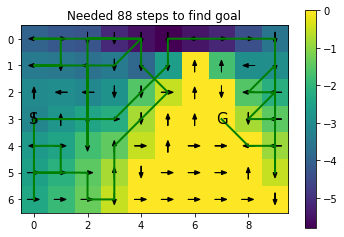

  6%|▋         | 13/200 [00:01<00:25,  7.23it/s]

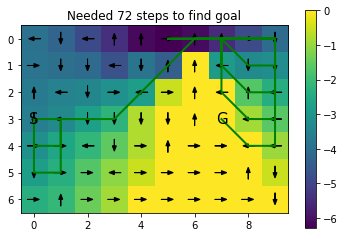

  8%|▊         | 15/200 [00:01<00:19,  9.62it/s]

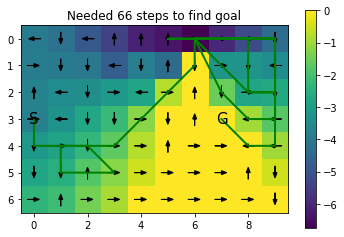

  8%|▊         | 16/200 [00:02<00:22,  8.20it/s]

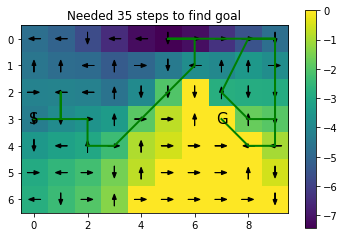

 10%|█         | 20/200 [00:02<00:12, 14.23it/s]

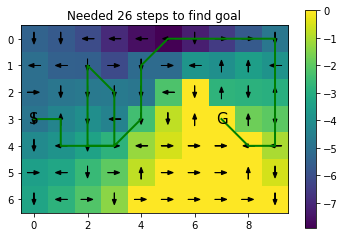

 12%|█▏        | 23/200 [00:02<00:10, 16.48it/s]

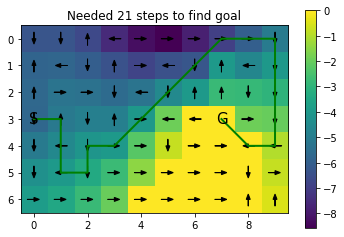

 16%|█▌        | 31/200 [00:02<00:05, 28.61it/s]

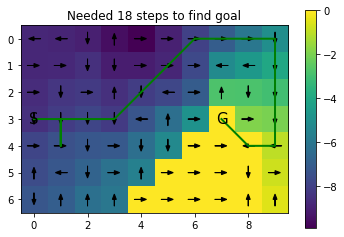

 30%|██▉       | 59/200 [00:02<00:01, 76.52it/s]

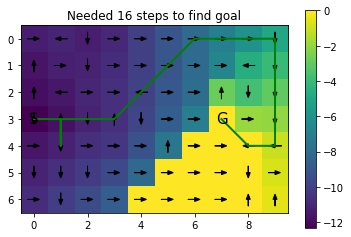

 50%|████▉     | 99/200 [00:02<00:00, 131.07it/s]

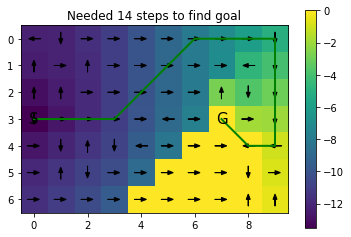

100%|██████████| 200/200 [00:03<00:00, 64.71it/s] 


### Progress from Episode to Episode
In the begining it fails to find the goal
Later the paths getting shorter and shorter

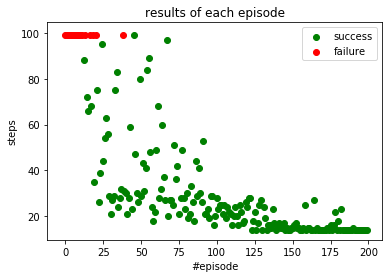

In [9]:
def windy_gridworld_q_learning():
    width = 10
    height = 7
    start = Position(0, 3)
    goal = Position(7, 3)
    wind = [0, 0, 0, -1, -1, -1, -2, -2, -1, 0]
    env = WindyGridWorld(width=width, height=height,
                         start=start, goal=goal, wind=wind)

    frames: List[Frame] = []
    episodes: List = []
    current_trace = []

    def step_hook(value, location):
        x = location % width
        y = location // width
        marker = Position(x, y)
        policy = np.argmax(value, axis=1)
        policy = np.reshape(policy, (height, width))
        value = np.max(value, axis=1)
        value = np.reshape(value, (height, width))
        current_trace.append(marker)
        frames.append(Frame(data=value, marker=marker,
                            trace=[*current_trace], policy=policy))

    class TerminationHook:
        def __init__(self):
            self.best_route = None

        def __call__(self, success: bool, step_index: int):
            episodes.append((success, step_index))
            if self.best_route is None and not success:
                pass
            elif success and (self.best_route is None or self.best_route > step_index):
                if self.best_route is None:
                    display(
                        Markdown('During training progress the path gets faster'))
                self.best_route = step_index
                pass
            else:
                del current_trace[:]
                return

            frame = frames[-1]
            if success:
                frame.trace.append(goal)
                title = f'Needed {step_index} steps to find goal'
            else:
                title = 'failed to find the goal'
            draw_frame(title=title, frame=frame, start=start,
                       goal=goal, arrow_map=arrow_map, success=success)
            del current_trace[:]

    def arrow_map(index: int):
        action = env.actions[index]
        return action.x, action.y

    display(Markdown('### Running Q-learning on Windy Gridworld\n'
                     'In the middle a wind blows the actor up.'
                     'Therefore the actor must reach the windless right edge.\n'
                     '### Failed approaches during During training'))

    qlearning_td0_control(
        environment=env, epsilon=0.05, step_size=0.5, number_of_episodes=200, step_hook=step_hook, termination_hook=TerminationHook())

    display(Markdown('### Progress from Episode to Episode\n'
                     'In the begining it fails to find the goal\n'
                     'Later the paths getting shorter and shorter'))

    successfull_episodes = [(i, steps)
                            for i, (success, steps) in enumerate(episodes) if success]
    failed_episodes = [(i, steps)
                       for i, (success, steps) in enumerate(episodes) if not success]
    plt.scatter(*zip(*successfull_episodes), color='green', label='success')
    plt.scatter(*zip(*failed_episodes), color='red', label='failure')
    plt.xlabel('#episode')
    plt.ylabel('steps')
    plt.legend()
    plt.title('results of each episode')
    plt.show()


windy_gridworld_q_learning()

## Expected Sarsa

\begin{align}
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha\left[ {\color{blue}R_{t+1} + \gamma\sum_a \pi(a|S_{t+1}) Q(S_{t+1}, a)} - Q(S_t, A_t) \right]
\end{align}

In [10]:
def expected_sarsa_td0_control(environment: dm_env.Environment, epsilon: float = 0.1, step_size: float = 0.5,
                               number_of_episodes: int = 10, max_episode_length: int = 100,
                               step_hook: Callable[[np.array, int],  None] = None, termination_hook: Callable[[bool, int], None] = None,
                               rng: np.random.RandomState = None):

    def target(Q, timestep, action):
        # epsilon greedy
        if rng.random() < epsilon:
            action = rng.randint(0, environment.action_spec().num_values)
        else:
            action = np.argmax(Q[timestep.observation, :])

        return timestep.reward + timestep.discount*Q[timestep.observation, action]

    return base_td0_control(target=target,
                            environment=environment, epsilon=epsilon, step_size=step_size,
                            number_of_episodes=number_of_episodes, max_episode_length=max_episode_length,
                            step_hook=step_hook, termination_hook=termination_hook,
                            rng=rng)


In [ ]:
# todo compare all TD algorithms in one scatter plot